In [1]:
# Import essential libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
from sklearn.model_selection import train_test_split  # To split data into training and test sets
from sklearn.preprocessing import StandardScaler  # For scaling features
from sklearn.ensemble import RandomForestClassifier  # For Random Forest model
from tensorflow.keras.models import Sequential  # To build neural network models
from tensorflow.keras.layers import Dense, Dropout  # Layers for neural network
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report  # Evaluation metrics
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input


In [2]:
# Load data tables from the MIMIC-III dataset
patients = pd.read_csv('PATIENTS.csv')
admissions = pd.read_csv('ADMISSIONS.csv')
icustays = pd.read_csv('ICUSTAYS.csv')
chartevents = pd.read_csv('CHARTEVENTS.csv', nrows=500000)  # Limit rows for faster loading
labevents = pd.read_csv('LABEVENTS.csv', nrows=500000)  # Limit rows for faster loading

# Display basic information about each DataFrame
print("Patients table shape:", patients.shape)
print("Admissions table shape:", admissions.shape)
print("ICU Stays table shape:", icustays.shape)
print("Chart Events table shape:", chartevents.shape)
print("Lab Events table shape:", labevents.shape)


Patients table shape: (46520, 8)
Admissions table shape: (58976, 19)
ICU Stays table shape: (61532, 12)
Chart Events table shape: (500000, 15)
Lab Events table shape: (500000, 9)


In [3]:
# Merge ICU stay data with admissions and patient data for a complete dataset
merged_df = icustays.merge(admissions, on=['SUBJECT_ID', 'HADM_ID'], how='inner') \
                    .merge(patients, on='SUBJECT_ID', how='inner')
print("Merged data shape:", merged_df.shape)


Merged data shape: (61532, 36)


In [4]:
# Create a binary sepsis label based on the diagnosis description
merged_df['SEPSIS_LABEL'] = merged_df['DIAGNOSIS'].str.contains('sepsis', case=False, na=False).astype(int)


In [5]:
merged_df.head()

,ROW_ID_x,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,...,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,SEPSIS_LABEL
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,...,1,1,251,F,2132-02-21 00:00:00,2198-02-18 00:00:00,2198-02-18 00:00:00,NaN,1,0
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,...,0,1,252,M,2130-09-30 00:00:00,NaN,NaN,NaN,0,1
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,...,0,1,253,M,2048-05-26 00:00:00,NaN,NaN,NaN,0,0
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,...,0,1,254,F,2074-11-30 00:00:00,NaN,NaN,NaN,0,0
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,...,0,1,255,M,2119-11-21 00:00:00,NaN,NaN,NaN,0,0


### Select Indicators of Sepsis

In [6]:
# Define ITEMIDs relevant to sepsis (adjust as necessary)
sepsis_itemids = [220045, 220179, 220180, 220210, 220277, 50983, 50971, 50885]


### Filter Data for the First 24 Hours of ICU Stay

In [7]:
# Convert CHARTTIME and INTIME to datetime format
chartevents['CHARTTIME'] = pd.to_datetime(chartevents['CHARTTIME'])
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])

# Test: Confirm the column types are datetime
assert pd.api.types.is_datetime64_any_dtype(chartevents['CHARTTIME']), "CHARTTIME column is not datetime"
assert pd.api.types.is_datetime64_any_dtype(icustays['INTIME']), "INTIME column is not datetime"
print("Datetime conversion test passed!")

Datetime conversion test passed!


In [8]:
# Merge chart events with ICU stay start times to calculate elapsed time
merged_chartevents = chartevents.merge(icustays[['ICUSTAY_ID', 'INTIME']], on='ICUSTAY_ID', how='inner')
chartevents_24hr = merged_chartevents[merged_chartevents['CHARTTIME'] <= merged_chartevents['INTIME'] + pd.Timedelta(hours=24)]

# Test: Confirm all times in chartevents_24hr are within 24 hours of INTIME
assert (chartevents_24hr['CHARTTIME'] - chartevents_24hr['INTIME']).dt.total_seconds().max() <= 24 * 3600, "Some records are beyond 24 hours"
print("24-hour filter test passed!")


24-hour filter test passed!


### Aggregate Vital Signs

In [9]:
# Filter for relevant sepsis-related ITEMIDs
filtered_sepsis_vitals = chartevents_24hr[chartevents_24hr['ITEMID'].isin(sepsis_itemids)]

# Aggregate statistics for mean, max, and min values
sepsis_agg = (
    filtered_sepsis_vitals.groupby(['ICUSTAY_ID', 'ITEMID'])['VALUENUM']
    .agg(['mean', 'max', 'min'])
    .unstack(fill_value=0)
)

# Flatten the multi-level columns by concatenating statistics and ITEMID
sepsis_agg.columns = [f"{stat}_{itemid}" for stat, itemid in sepsis_agg.columns]

# Diagnostic: Check which ITEMIDs are present and the column names
print("Unique ITEMIDs in filtered data:", filtered_sepsis_vitals['ITEMID'].unique())
print("Expected ITEMIDs:", sepsis_itemids)
print("Columns after aggregation:", sepsis_agg.columns)

# Define all expected columns based on `sepsis_itemids`
expected_columns = [f"{stat}_{itemid}" for itemid in sepsis_itemids for stat in ['mean', 'max', 'min']]

# Reindex `sepsis_agg` to ensure all expected columns are present, filling missing ones with 0
sepsis_features = sepsis_agg.reindex(columns=expected_columns, fill_value=0).reset_index()

# Adjust the assertion to verify that the final columns match the expected set
assert set(sepsis_features.columns) == set(['ICUSTAY_ID'] + expected_columns), \
    "Warning: Some expected ITEMIDs are missing from the final features."

# Display the first few rows of the final features
print("Final Sepsis Features DataFrame with Filled Missing Columns:")
sepsis_features.head()


Unique ITEMIDs in filtered data: [220045 220179 220180 220210 220277]
Expected ITEMIDs: [220045, 220179, 220180, 220210, 220277, 50983, 50971, 50885]
Columns after aggregation: Index(['mean_220045', 'mean_220179', 'mean_220180', 'mean_220210',
       'mean_220277', 'max_220045', 'max_220179', 'max_220180', 'max_220210',
       'max_220277', 'min_220045', 'min_220179', 'min_220180', 'min_220210',
       'min_220277'],
      dtype='object')
Final Sepsis Features DataFrame with Filled Missing Columns:


,ICUSTAY_ID,mean_220045,max_220045,min_220045,mean_220179,max_220179,min_220179,mean_220180,max_220180,min_220180,...,min_220277,mean_50983,max_50983,min_50983,mean_50971,max_50971,min_50971,mean_50885,max_50885,min_50885
0,200563.0,96.360000,108.0,87.0,129.631579,153.0,107.0,79.684211,101.0,62.0,...,96.0,0,0,0,0,0,0,0,0,0
1,200566.0,71.000000,84.0,59.0,129.333333,168.0,88.0,50.000000,72.0,31.0,...,96.0,0,0,0,0,0,0,0,0,0
2,200603.0,80.416667,82.0,80.0,88.769231,105.0,77.0,44.692308,51.0,38.0,...,87.0,0,0,0,0,0,0,0,0,0
3,200746.0,96.032258,111.0,86.0,120.400000,133.0,102.0,77.100000,91.0,60.0,...,80.0,0,0,0,0,0,0,0,0,0
4,200806.0,68.911765,84.0,55.0,110.911765,164.0,71.0,53.764706,120.0,30.0,...,79.0,0,0,0,0,0,0,0,0,0


### Prepare Data for Training

In [18]:
# Assuming 'SEPSIS_LABEL' is a column in merged_df for labeling cases of sepsis
X = sepsis_features.drop(columns=['ICUSTAY_ID']).values
y = merged_df.set_index('ICUSTAY_ID').loc[sepsis_features['ICUSTAY_ID'], 'SEPSIS_LABEL'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature data for neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



### Train Random Forest Models

In [ ]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


### Train FCNN Model

In [33]:
# Define and train a 5-layer Fully Connected Neural Network (FCNN)
fcnn_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Define input layer explicitly
    Dense(128, activation='relu'),           # First hidden layer
    Dropout(0.3),                            # Dropout for regularization
    Dense(64, activation='relu'),            # Second hidden layer
    Dropout(0.3),                            # Dropout for regularization
    Dense(32, activation='relu'),            # Third hidden layer (new layer)
    Dropout(0.3),                            # Dropout for regularization
    Dense(16, activation='relu'),            # Fourth hidden layer (new layer)
    Dropout(0.3),                            # Dropout for regularization
    Dense(1, activation='sigmoid')           # Output layer for binary classification
])

# Compile the model
fcnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = fcnn_model.fit(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test), batch_size=64)



Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7737 - loss: 0.6040 - val_accuracy: 0.9645 - val_loss: 0.5501
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9036 - loss: 0.5160 - val_accuracy: 0.9645 - val_loss: 0.4553
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9333 - loss: 0.4229 - val_accuracy: 0.9645 - val_loss: 0.3633
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9281 - loss: 0.3501 - val_accuracy: 0.9645 - val_loss: 0.2935
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9443 - loss: 0.2936 - val_accuracy: 0.9645 - val_loss: 0.2614
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9380 - loss: 0.2960 - val_accuracy: 0.9645 - val_loss: 0.2549
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9454 - loss: 0.2115 - val_accuracy: 0.9645 - val_loss: 0.2580
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9406 - loss: 0.2119 - val_accuracy: 0.9645 - val_loss: 0.2627
Epoch 9

In [34]:
# Evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Evaluate the FCNN model
y_pred_fcnn = (fcnn_model.predict(X_test_scaled) > 0.5).astype("int32")
fcnn_accuracy = accuracy_score(y_test, y_pred_fcnn)
fcnn_auc = roc_auc_score(y_test, fcnn_model.predict(X_test_scaled))

# Print evaluation metrics
print("Random Forest - Accuracy:", rf_accuracy, "AUC-ROC:", rf_auc)
print("FCNN - Accuracy:", fcnn_accuracy, "AUC-ROC:", fcnn_auc)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
Random Forest - Accuracy: 0.9645390070921985 AUC-ROC: 0.7235294117647059
FCNN - Accuracy: 0.9645390070921985 AUC-ROC: 0.39705882352941174


### Visualize Training Performance

Available keys in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


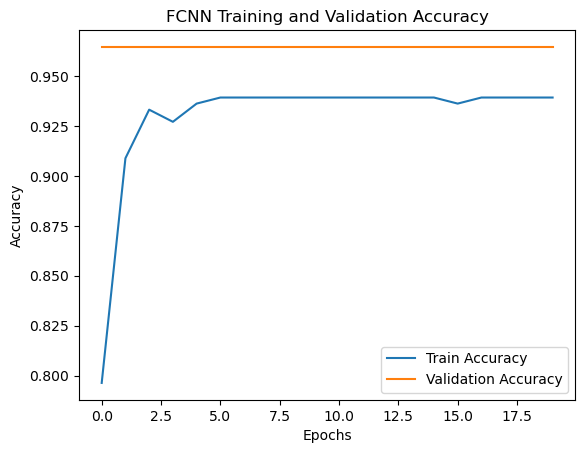

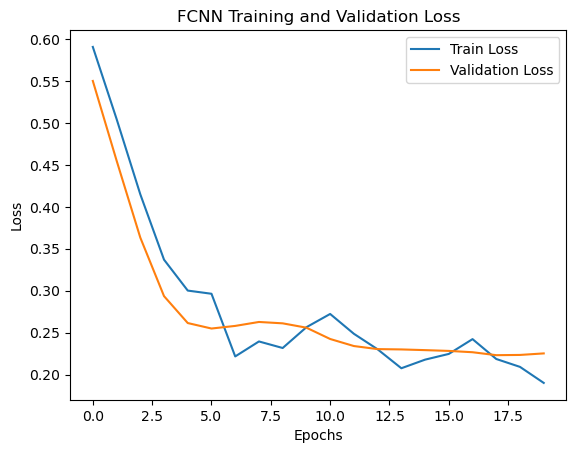

In [35]:
# Plot training and validation accuracy for FCNN
# Print available keys in history to confirm accuracy key presence
print("Available keys in history:", history.history.keys())

# Plot training and validation accuracy for FCNN
plt.plot(history.history.get('accuracy', []), label='Train Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("FCNN Training and Validation Accuracy")
plt.show()

# Plot training and validation loss for FCNN
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("FCNN Training and Validation Loss")
plt.show()

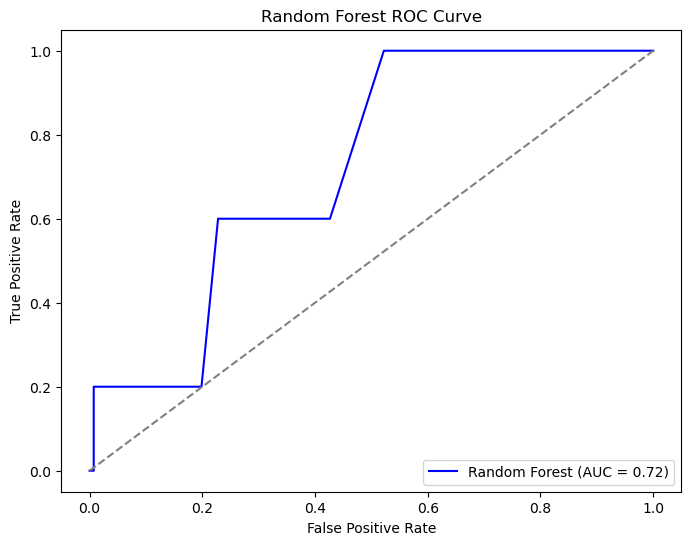

In [32]:
from sklearn.metrics import roc_curve, auc

# Get probabilities for positive class (sepsis)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [30]:
print("Model Performance Summary")
print("-------------------------")
print("Random Forest - Accuracy:", rf_accuracy, "| AUC-ROC:", rf_auc)
print("FCNN - Accuracy:", fcnn_accuracy, "| AUC-ROC:", fcnn_auc)


Model Performance Summary
-------------------------
Random Forest - Accuracy: 0.9645390070921985 | AUC-ROC: 0.7235294117647059
FCNN - Accuracy: 0.9645390070921985 | AUC-ROC: 0.3588235294117647
